In [1]:
import numpy as np
import matplotlib.pyplot as plt
from control.matlab import *
from control import bode, tf, hinfsyn
from control.matlab import logspace, feedback, step, nyquist, ss

from for_plot import bodeplot_set, plot_set

In [2]:
Kf = 9.512* 10**-1
m = 1 * 10**-3
Tp = 2.54* 10**-7
Kp = Kf/m/Tp

In [3]:
Pmech_info = {
 1:{"f":90, "gi":0.5, "Ai":1.0},
 2:{"f":4100, "gi":0.02, "Ai":-1.0},
 3:{"f":8200, "gi":0.02, "Ai":1.0},
 4:{"f":12300, "gi":0.02, "Ai":-1.0},
 5:{"f":16400, "gi":0.02, "Ai":1.0},
 6:{"f":3000, "gi":0.005, "Ai":0.01},
 7:{"f":5000, "gi":0.001, "Ai":0.03},
}

In [4]:
def calc_P_element(f_params):
    w_i = f_params["f"]*2*np.pi
    P_element = tf([0,0,f_params["Ai"]],[1, 2*f_params["gi"]*w_i, w_i**2])
    return P_element

In [5]:
def calc_P_mech(max_dim, dim_params):
    P_mech = 0
    for dim, param in dim_params.items():
        if dim > max_dim:
            break
        else:
            P_mech += calc_P_element(param)
    return P_mech


In [6]:
P_mech = calc_P_mech(7, Pmech_info)
P_nominal = calc_P_mech(1, Pmech_info)

C:\Users\takahashi\anaconda3\envs\control\lib\site-packages\control\freqplot.py:185: FutureWarning: 'Plot' keyword is deprecated in bode_plot; use 'plot'
  warnings.warn("'Plot' keyword is deprecated in bode_plot; use 'plot'",
C:\Users\takahashi\anaconda3\envs\control\lib\site-packages\control\freqplot.py:185: FutureWarning: 'Plot' keyword is deprecated in bode_plot; use 'plot'
  warnings.warn("'Plot' keyword is deprecated in bode_plot; use 'plot'",


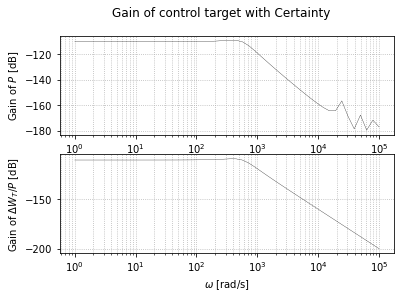

In [7]:
fig, ax = plt.subplots(2, 1)


gain, _, w = bode(P_mech, logspace(0, 5), Plot = False)
ax[0].semilogx(w, 20*np.log10(gain), color='k', lw=0.3)    
gain, _, w = bode(P_nominal, logspace(0, 5), Plot = False)
ax[1].semilogx(w, 20*np.log10(gain), color='k', lw=0.3)   
bodeplot_set(ax)
ax[0].set_xlabel('$\omega$ [rad/s]')
ax[0].set_ylabel('Gain of $P$ [dB]')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Gain of $\Delta W_T/P$ [dB]')

fig.suptitle("Gain of control target with Certainty")
plt.show()

In [8]:
delta_m = (P_mech-P_nominal)/P_nominal


C:\Users\takahashi\anaconda3\envs\control\lib\site-packages\control\freqplot.py:185: FutureWarning: 'Plot' keyword is deprecated in bode_plot; use 'plot'
  warnings.warn("'Plot' keyword is deprecated in bode_plot; use 'plot'",


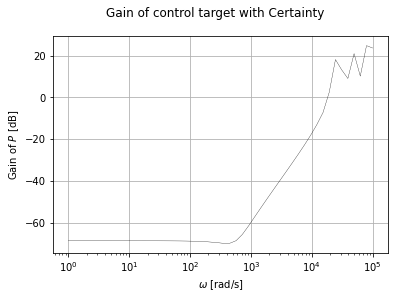

In [9]:
fig, ax = plt.subplots(1, 1)


gain, _, w = bode(delta_m, logspace(0, 5), Plot = False)
ax.semilogx(w, 20*np.log10(gain), color='k', lw=0.3)    
ax.set_xlabel('$\omega$ [rad/s]')
ax.set_ylabel('Gain of $P$ [dB]')
ax.grid()

fig.suptitle("Gain of control target with Certainty")
plt.show()

In [10]:
w_1 = 2*np.pi*4500
gz_1 = 0.3
w_2 = 2*np.pi*800
gz_2 = 1
gt = 22

In [11]:
s =tf('s')
Wt = ((s**2+2*gz_2*w_2*s+w_2**2)/(s**2+2*gz_1*w_1*s+w_1**2))**2*gt

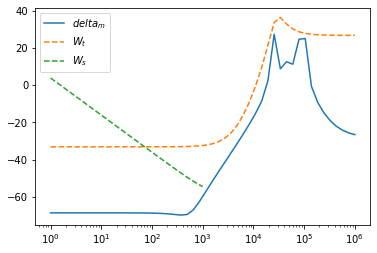

In [40]:

plt.figure(3)
#bodemag(Ws,Wt,'--',w);
Ws = tf([1, 2*np.pi*250],[1,2*np.pi*0.01])*1*10**-3
mag, phase, om  = bode(delta_m, logspace(0,6), plot=False);
mag2,phase2,om2 = bode(Wt, logspace(0,6), plot=False);
mag3, phase3, om3  = bode(Ws, logspace(0,3), plot=False);
plt.semilogx(om,  20*np.log10(mag), label='$delta_m$');
plt.semilogx(om2, 20*np.log10(mag2), '--', label='$W_t$');
plt.semilogx(om3, 20*np.log10(mag3), '--', label='$W_s$');
#legend('Ws','Wt',4);
plt.legend()


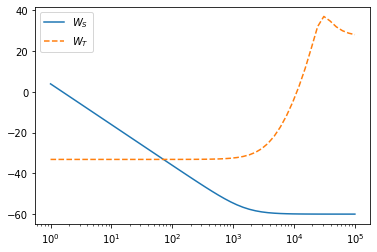

In [41]:
#%% 重み関数の定義
s = tf('s');
Weps = 0.04;          #% Weps


plt.figure(3)
#bodemag(Ws,Wt,'--',w);
mag, phase, om  = bode(Ws, logspace(0,5), plot=False);
mag2,phase2,om2 = bode(Wt, logspace(0,5), plot=False);
plt.semilogx(om,  20*np.log10(mag), label='$W_S$');
plt.semilogx(om2, 20*np.log10(mag2), '--', label='$W_T$');
#legend('Ws','Wt',4);z
plt.legend()
L = Ws*P_nominal
num = [[L.num[0][0],    Weps*Ws.num[0][0], L.num[0][0]], 
       [         [0],    [0],    Wt.num[0][0]],
       [P_nominal.num[0][0], [Weps], (-P_nominal).num[0][0]]]
den = [[L.den[0][0],    Ws.den[0][0], L.den[0][0]], 
       [         [1],    [1],    Wt.den[0][0]],
       [P_nominal.den[0][0],    [1], (-P_nominal).den[0][0]]]
G_ = tf(num, den)
G = tf2ss(G_)


0.9999936800065102


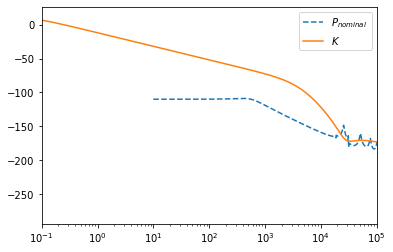

In [42]:
K, CL, gam, rcond = hinfsyn(G,1,1)
print( gam )

plt.figure(4)
mag1, phase1, om1 = bode( P_mech, plot=False );
plt.semilogx( om1, 20*np.log10(mag1), '--', label='$P_{nominal}$' );
mag2, phase2, om2 = bode( K, plot=False );
plt.semilogx( om2, 20*np.log10(mag2), label='$K$' );
plt.xlim(1e-1, 1e5);
plt.legend()

In [43]:
ss2tf(K)

TransferFunction(array([-2.53988725e-04, -8.76126166e+00, -4.84148194e+05, -7.16299748e+09,
       -1.66373481e+14, -9.39953353e+16, -5.19073339e+19]), array([1.00000000e+00, 2.06717425e+04, 1.63287982e+08, 6.00172712e+11,
       9.74166026e+14, 5.23504697e+17, 2.04171041e+20, 1.28267030e+19]))